# Exploratory Data Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import sys

# Custom functions

sys.path.insert(1, '../src')
from custom_plots import *

import shap

# Options
pd.options.display.max_rows = 200
pd.options.display.max_columns = 200
%matplotlib inline
sns.set_theme(style="white")

# Convenience for working with external src code files
%load_ext autoreload
%autoreload 2

## Import protest data

In [2]:
# Import data from Modeling notebook
engine = create_engine('sqlite:///../data/processed/all_data.db')
with engine.begin() as connection:
    df = pd.read_sql('SELECT * FROM all_modeled_data', connection)
    
df['target_categorical'] = ['Revolution' if x == 1 else \
                            "No Revolution" for x in df.target]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11840 entries, 0 to 11839
Data columns (total 36 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   country                            11840 non-null  object 
 1   region                             11840 non-null  object 
 2   protesterviolence                  11840 non-null  float64
 3   demand_labor-wage-dispute          11840 non-null  float64
 4   demand_land-farm-issue             11840 non-null  float64
 5   demand_police-brutality            11840 non-null  float64
 6   demand_political-behavior/process  11840 non-null  float64
 7   demand_price-increases/tax-policy  11840 non-null  float64
 8   demand_removal-of-politician       11840 non-null  float64
 9   demand_social-restrictions         11840 non-null  float64
 10  participants_log                   11840 non-null  float64
 11  duration_days_log                  11840 non-null  flo

#### Categorize all features for analysis

Print list of any features that aren't in one of the below bins as a QC.

In [13]:
demands = ['demand_labor-wage-dispute', 'demand_land-farm-issue', 
           'demand_police-brutality', 'demand_political-behavior/process', 
           'demand_price-increases/tax-policy', 
           'demand_removal-of-politician', 'demand_social-restrictions']

binary = demands+['protesterviolence', 'military', 'legelec', 'exelec', 
                  'defmin', 'execnat', 'oppmajh', 'gq', 'gqi', 'auton']

continuous = ['protestnumber_log', 'participants_log', 'yrsoffc', 
              'totalseats', 'numvote', 'duration_days_log', 'termlimit', 
              'maj', 'herfgov', 'checks', 'stabs_strict', 'xconst', 
              'tensys_strict']

categorical = ['region', 'system', 'country', 'execrel']

targets = ['target', 'target_categorical']

remainders = df.drop(continuous+categorical+binary+targets, axis=1).columns

if remainders.shape==(0,):
    print("All features successfully bucketed")
else:
    print('Remaining columns to be assigned to various bucket:')
    for col in remainders:
        print(col, '\n', df[col].value_counts(), '\n')

All features successfully bucketed


## Correlation matrix

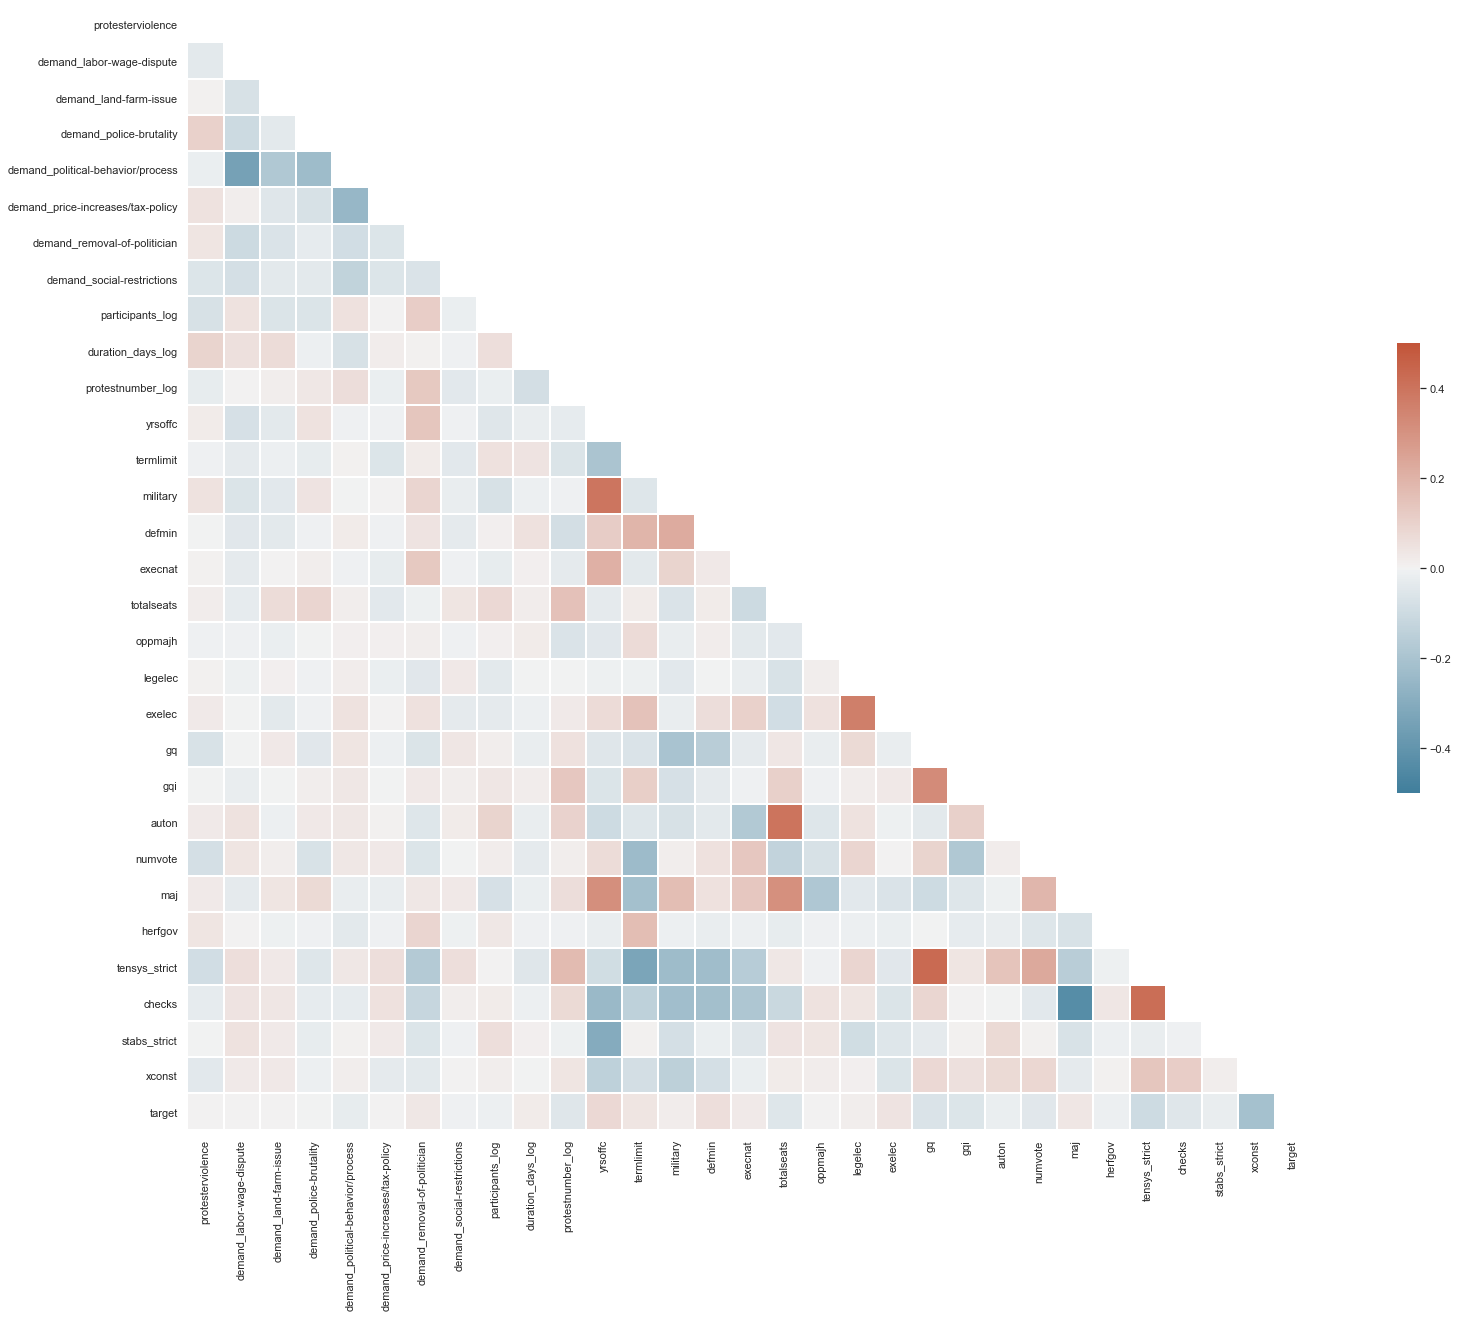

In [14]:
custom_plot_matrix(df, max_corr=0.5)

### Protestnumber

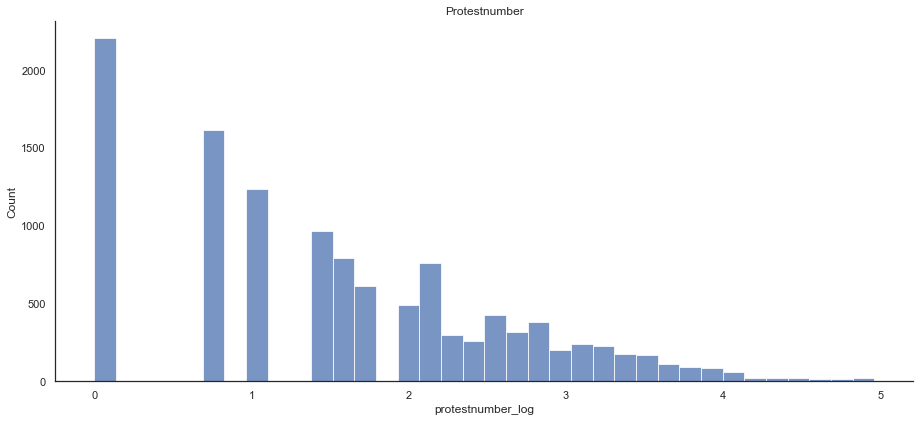

In [19]:
fig = sns.displot(df.protestnumber_log)
fig.fig.set_figwidth(15)
fig.fig.set_figheight(6)
plt.title('Protestnumber');

### Protester Demands

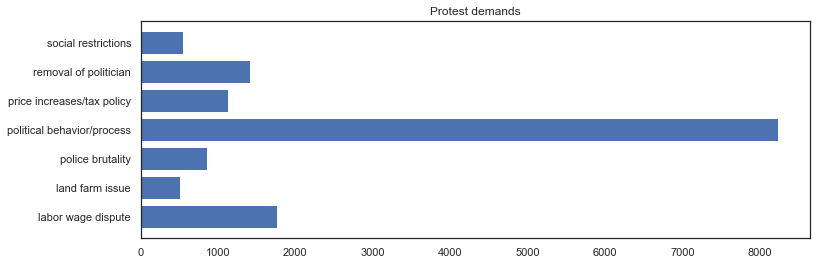

In [21]:
plt.figure(figsize=(12, 4))
bar = df[demands].sum()
cols = [x[7:].replace('-', ' ') for x in bar.index]
plt.barh(cols, bar.values)
plt.title('Protest demands')
plt.savefig('../images/protest_demands.png');

 **Target:** We see that the protester demand for "removal of politician" is most strongly correlated with an impending revolution. 

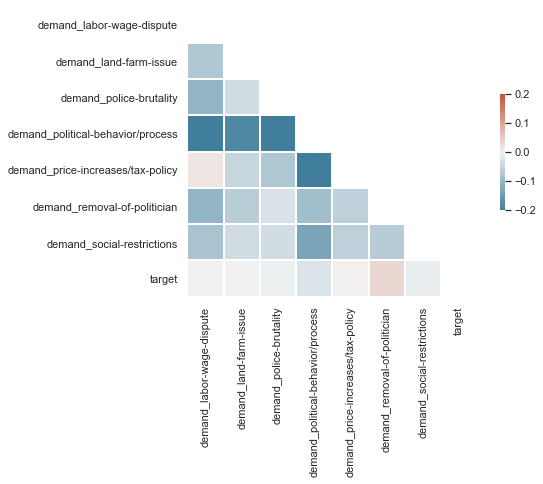

In [22]:
custom_plot_matrix(df[demands+targets], max_corr=0.2)

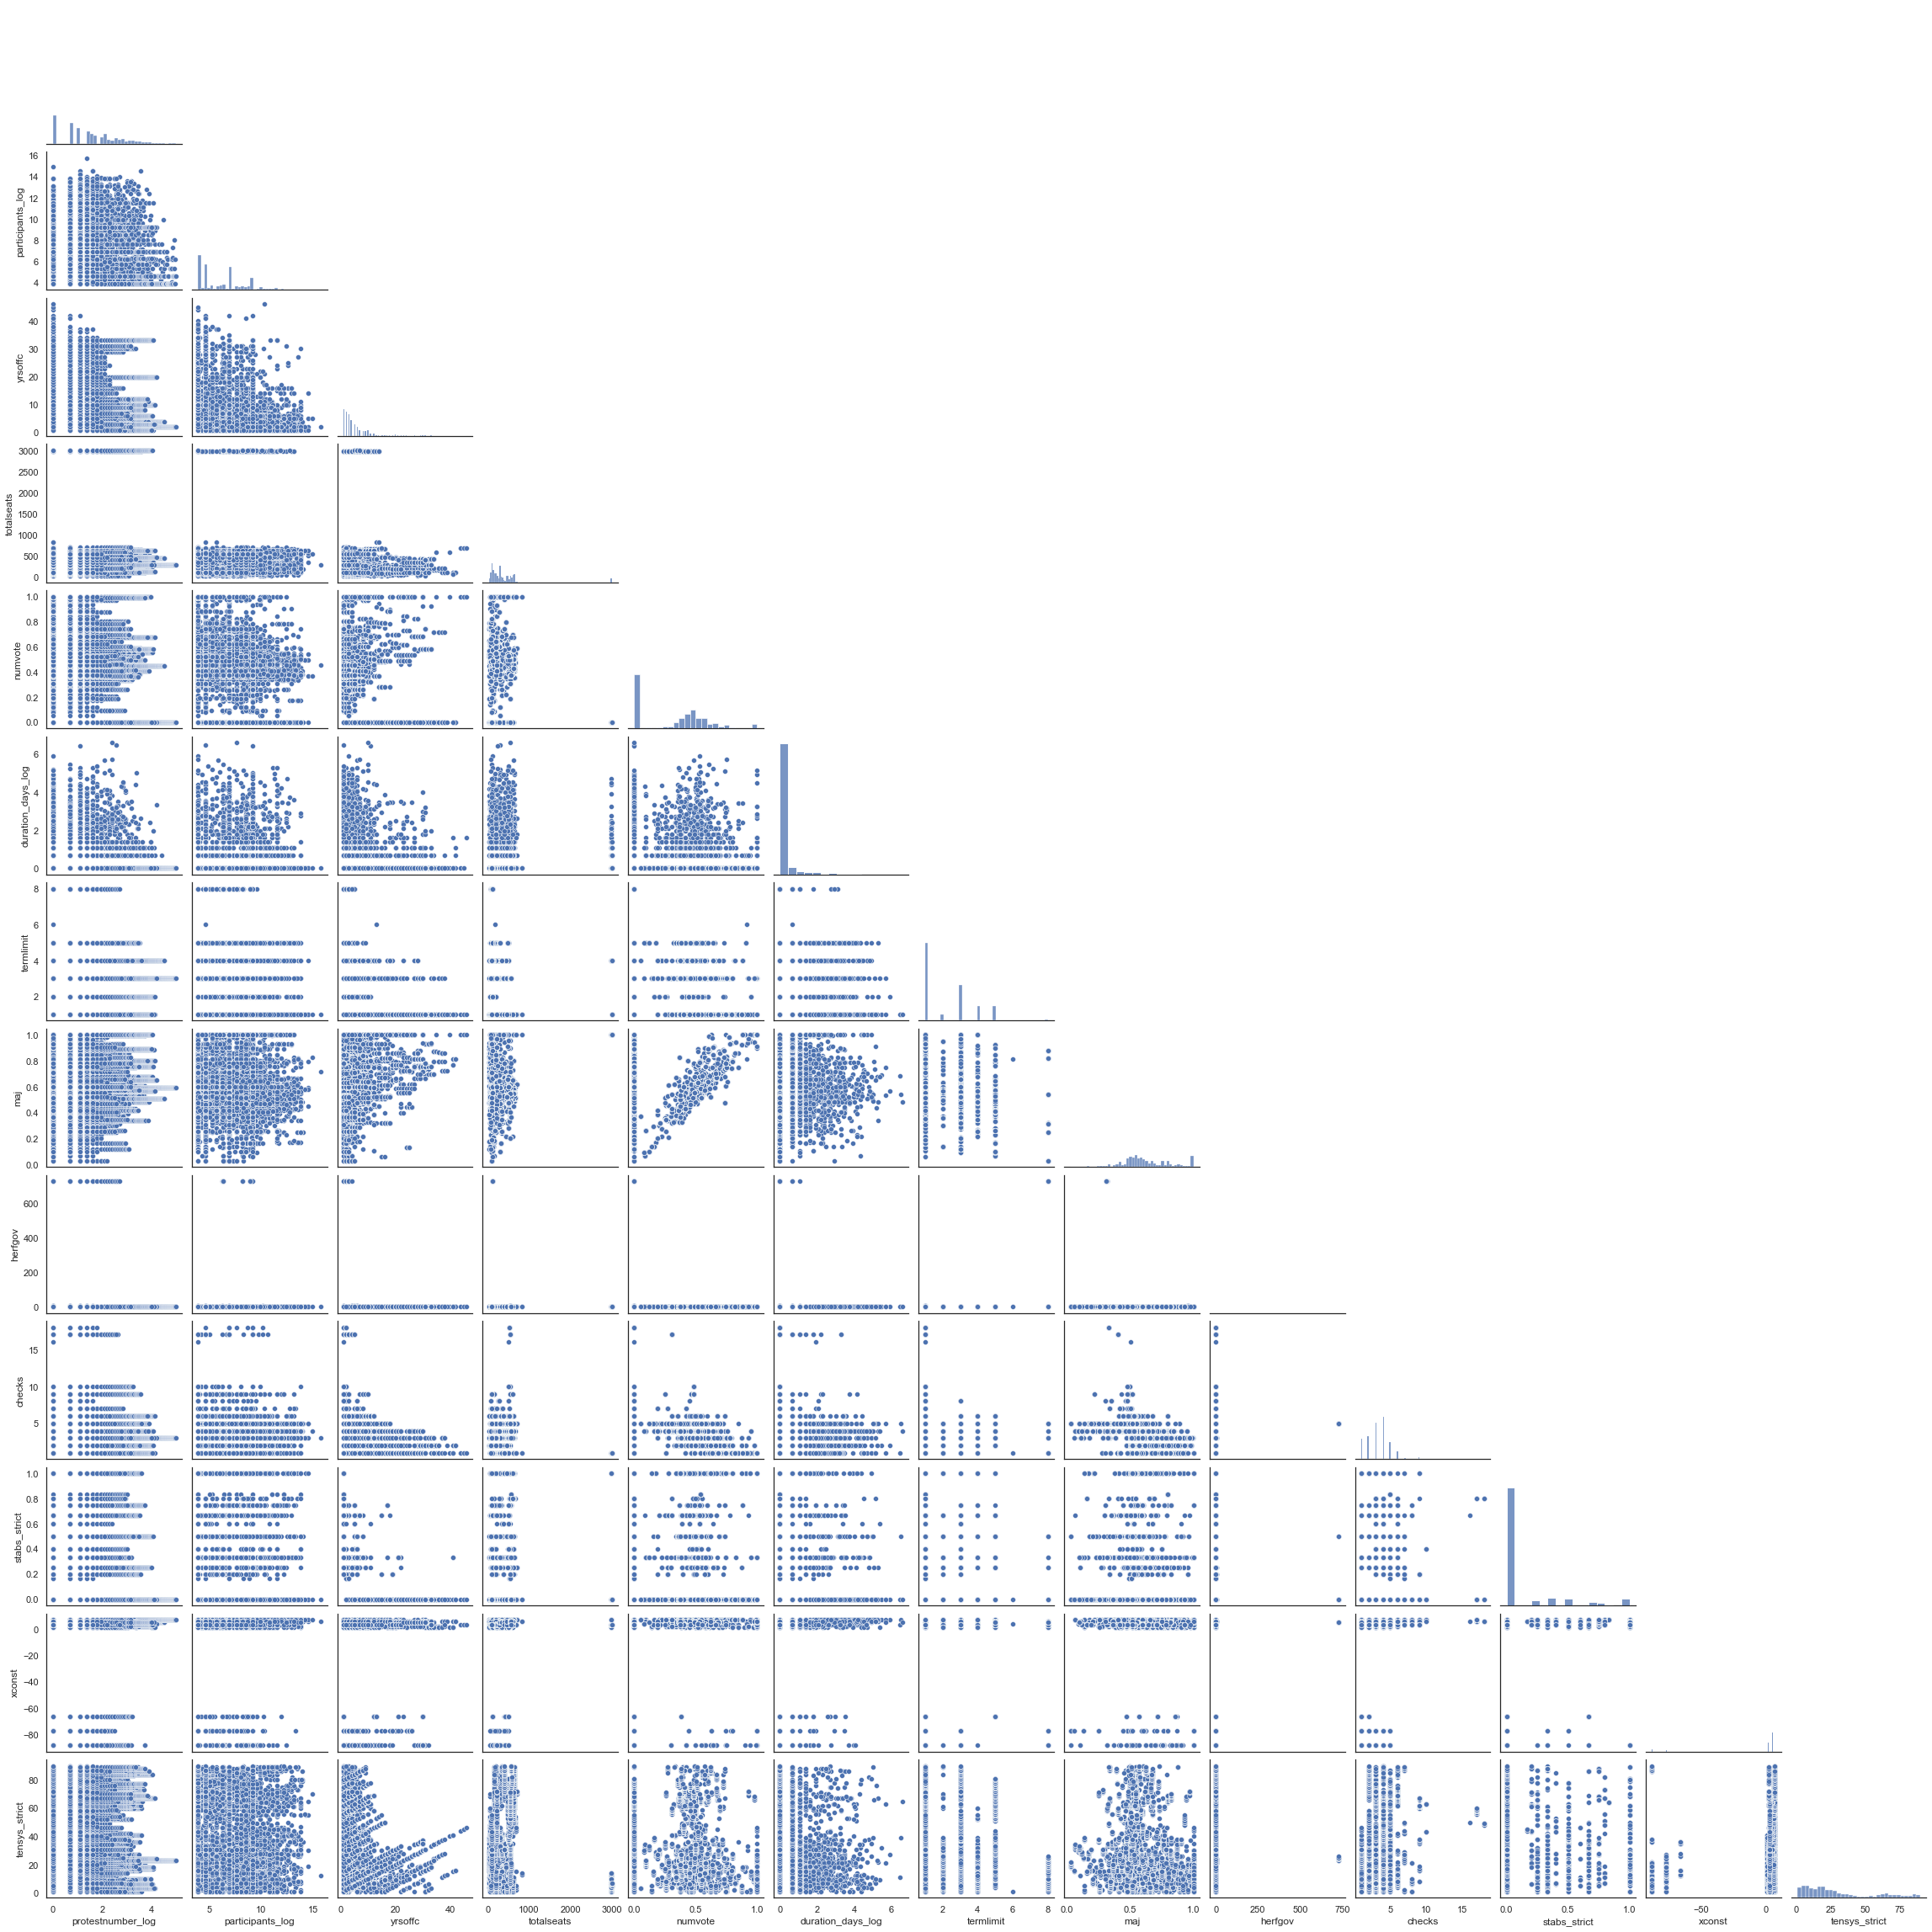

In [25]:
sns.pairplot(df[continuous], corner=True);

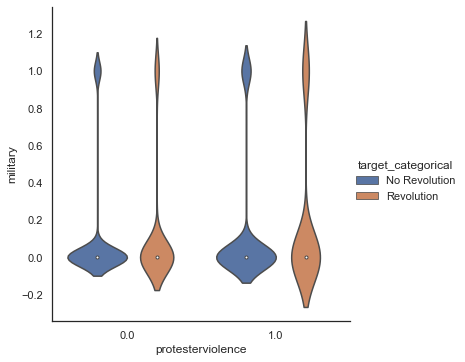

In [29]:
sns.catplot(y='military', x='protesterviolence',kind="violin", 
            hue='target_categorical', data=df);

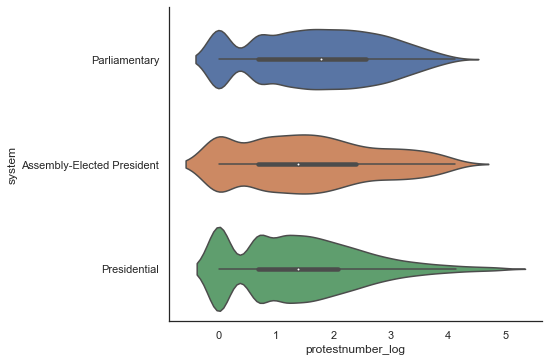

In [38]:
fig = sns.catplot(x='protestnumber_log', y='system',kind="violin", data=df)

fig.fig.set_figwidth(10)
fig.fig.set_figheight(5)

In [39]:
df.yrsoffc.mean()+3*df.yrsoffc.std()

24.728651061651618

In [40]:
high_end = df.totalseats.mean()+3*df.totalseats.std()
print('High end:', high_end)
df.loc[df.totalseats>high_end].totalseats.value_counts()

High end: 1787.117072077864


2987.0    136
2978.0    114
3000.0     65
Name: totalseats, dtype: int64

In [41]:
df.totalseats.value_counts().head(30)

120.0     509
166.0     389
577.0     354
300.0     327
500.0     313
290.0     257
450.0     256
299.0     241
150.0     230
650.0     200
128.0     198
631.0     171
543.0     168
350.0     154
360.0     140
550.0     140
301.0     139
645.0     137
2987.0    136
296.0     135
630.0     132
513.0     125
207.0     122
2978.0    114
621.0     113
462.0     112
460.0     108
99.0      105
83.0      103
113.0      96
Name: totalseats, dtype: int64

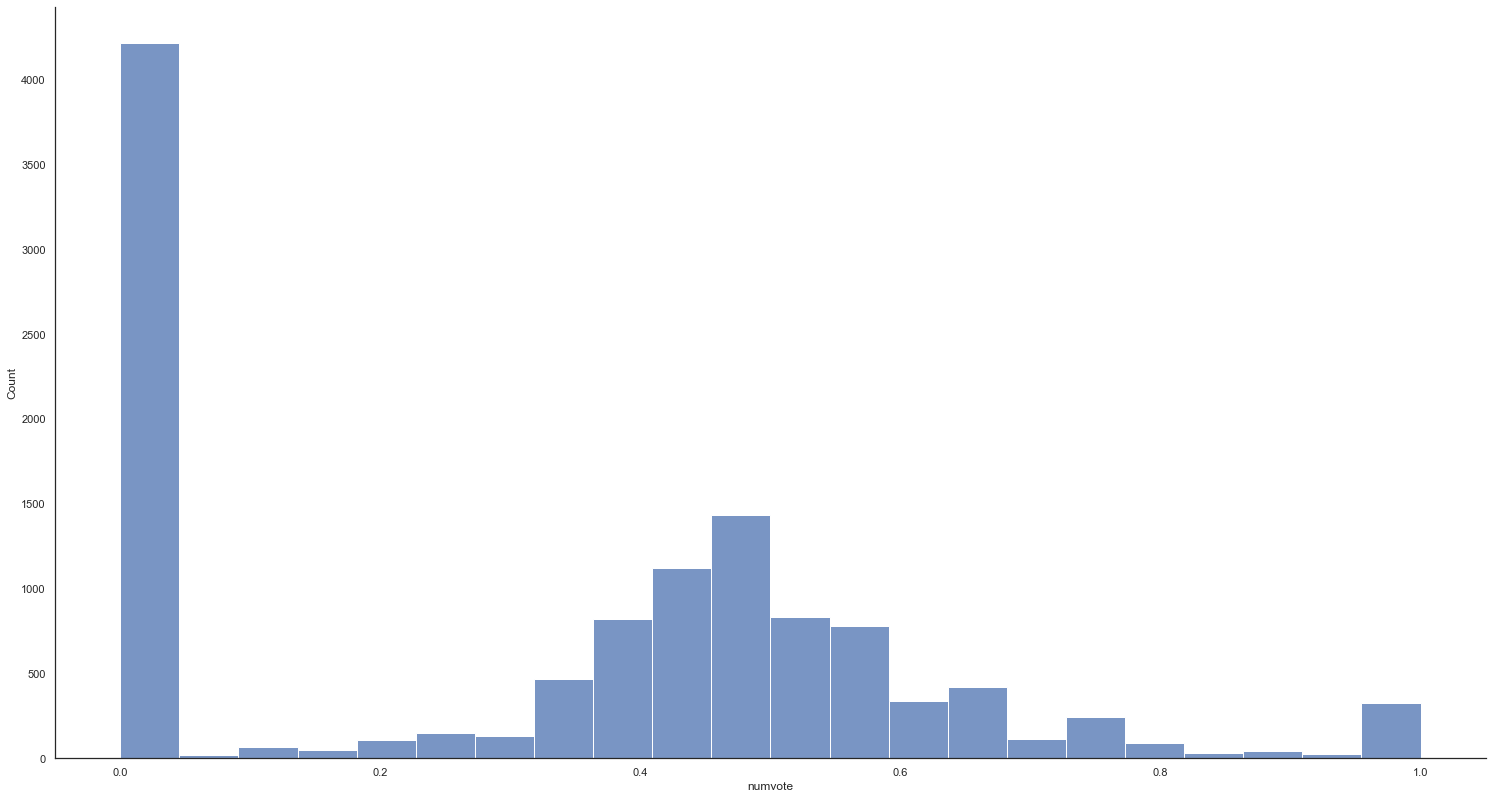

In [42]:
fig = sns.displot(df.numvote)
fig.fig.set_figwidth(25)
fig.fig.set_figheight(12.5)

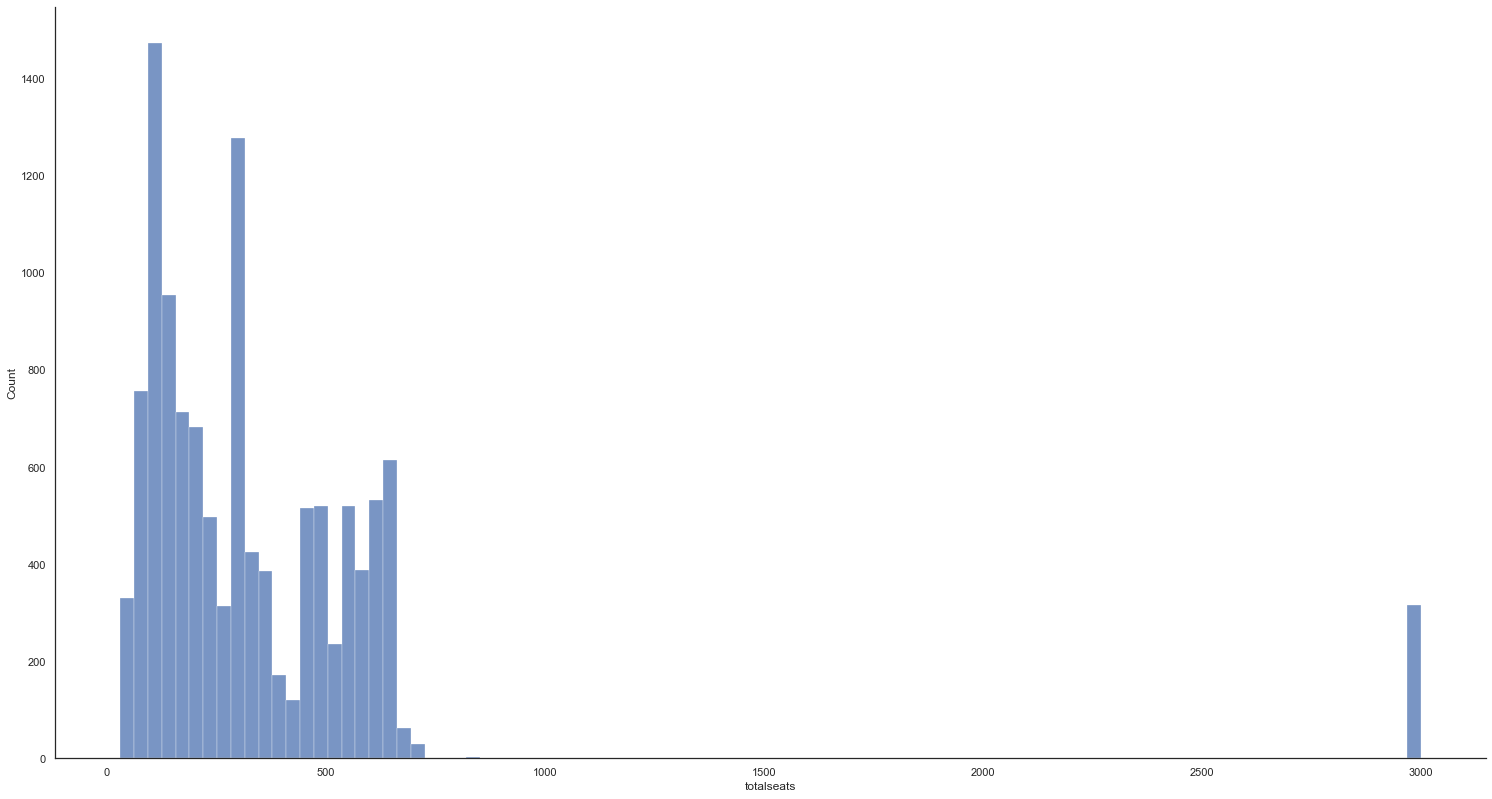

In [43]:
fig = sns.displot(df.totalseats)
fig.fig.set_figwidth(25)
fig.fig.set_figheight(12.5)

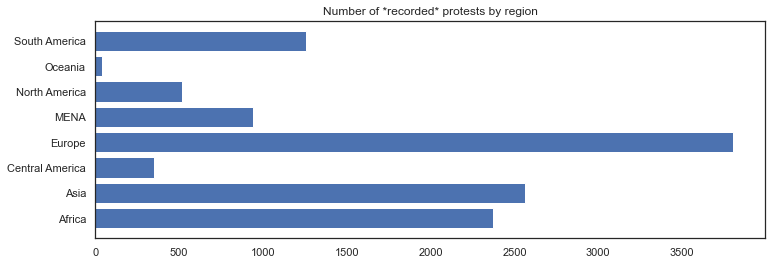

In [44]:
plt.figure(figsize=(12, 4))
protest_ct = pd.get_dummies(df.region).sum()
plt.barh(protest_ct.index, protest_ct.values)
plt.title('Number of *recorded* protests by region');
plt.savefig('../images/protests_by_region.png');

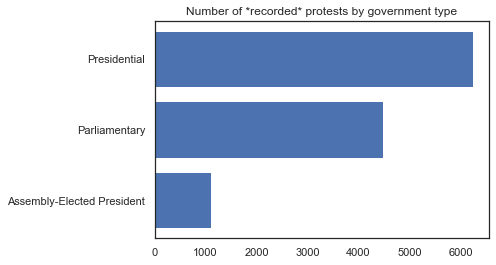

In [45]:
protest_ct = pd.get_dummies(df.system).sum()
plt.barh(protest_ct.index, protest_ct.values)
plt.title('Number of *recorded* protests by government type');